In [1]:
import numpy as np
import pandas as pd
from functions import *
from schemes import *
from plot import * 
from Kepler import *
from adaptive import *

%matplotlib inline

In [2]:
def Optimised_acceleration(rs, G, masses):

    N = len(rs)

    Fs = np.zeros_like(rs).astype('float64') # empty vector of forces 

    for i in range(N):
        for j in range(i+1, N):
            rij = rs[j] - rs[i]
            rij_mag = np.linalg.norm(rij)
            F = (rij) / (rij_mag ** 3)
            Fs[i] += F * masses[j]
            Fs[j] += - F * masses[i]
        
    return G * Fs

def Optimised_Force(rs, G, masses):
    N = len(rs)

    Fs = np.zeros_like(rs).astype('float64') # empty vector of forces 

    for i in range(N):
        for j in range(i+1, N):
            rij = rs[j] - rs[i]
            rij_mag = np.linalg.norm(rij)
            F = masses[i] * masses[j] * (rij) / (rij_mag ** 3)
            Fs[i] += F
            Fs[j] += - F
        
    return G * Fs

In [3]:
def Optimised_FR_Step(r0s, v0s, h, G, masses):
    p = + 0.1786178958448091E+00
    l = - 0.2123418310626054E+00
    c = - 0.6626458266981849E-01

    a = (1 - 2 * l)
    
    r1s = r0s + p * h * v0s
    v1s = v0s + a * 0.5 * h * Optimised_acceleration(r1s, G, masses)
    r2s = r1s + c * h * v1s
    v2s = v1s + l * h * Optimised_acceleration(r2s, G, masses)
    r3s = r2s + (1 - 2*(c + p)) * h * v2s
    v3s = v2s + l * h * Optimised_acceleration(r3s, G, masses)
    r4s = r3s + c * h * v3s
    v4s = v3s + a * 0.5 * h * Optimised_acceleration(r4s, G, masses)
    r5s = r4s + p * h * v4s
    
    return r5s, v4s

In [4]:
# gravity
G = 1

m1 = 1 
m2 = 1 
m3 = 1

# position
r1 = np.array([0,0.0,0.0], dtype="float64")
r2 = np.array([1,0.0,0.0], dtype="float64")
r3 = np.array([-1,0.0,0.0], dtype="float64")

p1 = 0.347111
p2 = 0.532728

# velocity 
v1 = np.array([-2 * p1,-2*p2,0], dtype="float64")
v2 = np.array([p1,p2,0], dtype="float64")
v3 = np.array([p1,p2,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

T = 100
hlim = 1e-3
C = 0.1

In [5]:
def solver(scheme, T, C, hlim, r0s, v0s, G, masses, h0 = 0.01, t0 = 0):
    
    # reposition centre of mass to origin with no momentum 
    rcom, vcom = CentreOfMass(r0s, v0s, masses)
    r0s -= rcom
    v0s -= vcom
    
    # Make a copy of initial values
    rs = np.copy(r0s)
    vs = np.copy(v0s)
    t = t0
    h = h0
    
    # Initialize our saved trajectories to be blank 
    t_vals = [t0]
    rs_traj = [r0s] 
    vs_traj = [v0s] 
    # ke_traj = [KineticEnergy(v0s, masses)]
    # pe_traj = [PotentialEnergy(r0s, G, masses)]
    times = 0 

    rs, vs = scheme(rs, vs, h, G, masses) 
    
    # run scheme for requried number of steps 
    while t <= T:
        t1 = time.time()

        h = C * findh(rs, vs) # proposed timestep

        rs_bar, vs_bar = scheme(rs, vs, h, G, masses)
        h_bar = C * findh(rs_bar, vs_bar) # proposed timestep

        h_new = (h + h_bar) / 2
        
        rs, vs = scheme(rs, vs, h_new, G, masses)

        times += time.time() - t1

        # ke = KineticEnergy(vs, masses)
        # pe = PotentialEnergy(rs, G, masses)
        
        t += h_new

        ## append values to trajectories 
        t_vals = t_vals + [t]
        rs_traj = rs_traj + [rs] 
        vs_traj = vs_traj + [vs]
        
    # Make trajectories into numpy arrays
    rs_traj = np.array(rs_traj)
    vs_traj = np.array(vs_traj) 
    
    # reposition centre of mass to origin with no momentum 
    rs_traj = np.array([rs + rcom for rs in rs_traj])
    vs_traj = np.array([vs + vcom for vs in vs_traj])
    
    return (t_vals, rs_traj, vs_traj, times)# , ke_traj, pe_traj

In [6]:
traj = solver(PEFRLStep, T, C, hlim, r0s, v0s, G, masses)

In [7]:
traj = solver(Optimised_FR_Step, T, C, hlim, r0s, v0s, G, masses)

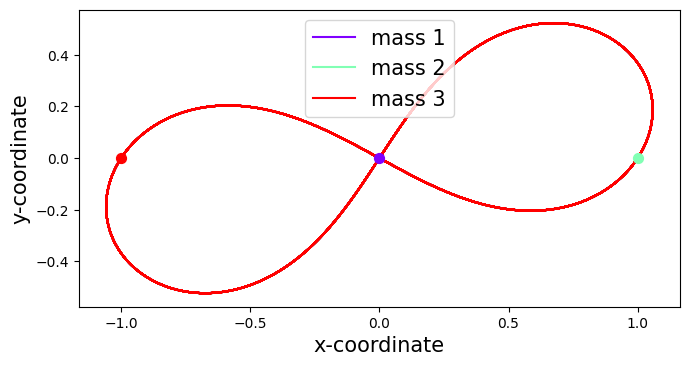

In [8]:
t_vals, rs_traj, vs_traj, times = traj
PlotOrbits((t_vals, rs_traj, vs_traj, times, 1, 1))

In [9]:
print(KineticEnergy(vs_traj[0], masses) + PotentialEnergy(rs_traj[0], G, masses))

TypeError: unsupported operand type(s) for /: 'list' and 'int'